## Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

y = 'SalePrice'
y_log = 'SalePrice_log'

# One-hot encode categoricals

#### Encode "HeatSystem"

In [3]:
# First, convert encoded values to text values so we can understand their meaning
keys = get_lookups(108)
print('Keys:', keys, '\n')
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "").replace('-','') if x!='0' else 'Other'
heating = df_main.HeatSystem.apply(convert_to_keys)
print('Original breakdown:\n{}'.format(heating.value_counts()))

# We see that Gravity and Radiant are very uncommon. Let's lump them into the "Other" category
simplify = lambda x: 'Other' if x in ['Gravity', 'Radiant'] else x
heating = heating.apply(simplify)
print('\nImproved categorization:\n{}'.format(heating.value_counts()))

# Now that we have appropriate categorization, let's one-hot encode
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False).drop('Heating_ForcedAir', axis=1) # Choose to drop ForcedAir

#Adjust df_main accordingly
df_main.drop('HeatSystem', axis=1, inplace=True)
df_main = pd.concat([df_main, heating_dummies], axis=1)

Keys: {'1': 'Floor-Wall', '2': 'Gravity', '3': 'Radiant', '4': 'Elec BB', '5': 'Forced Air', '6': 'Hot Water', '7': 'Heat Pump', '8': 'Other'} 

Original breakdown:
ForcedAir    14148
HeatPump      1536
ElecBB        1124
FloorWall      564
HotWater       447
Radiant        261
Gravity         38
Other           25
Name: HeatSystem, dtype: int64

Improved categorization:
ForcedAir    14148
HeatPump      1536
ElecBB        1124
FloorWall      564
HotWater       447
Other          324
Name: HeatSystem, dtype: int64


#### Encode "Condition"

In [4]:
keys = get_lookups(83)
print('Keys:', keys)
convert_to_keys = lambda x: keys[x].replace(' ', '')
condition = df_main.Condition.apply(convert_to_keys)
print('\nBreakdown of conditions:\n{}'.format(condition.value_counts()))

condition_dummies = pd.get_dummies(condition, prefix='Condition', drop_first=False).drop('Condition_Average', axis=1)
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

Keys: {'1': 'Poor', '2': 'Fair', '3': 'Average', '4': 'Good', '5': 'Very Good'}

Breakdown of conditions:
Average     11384
Good         4716
VeryGood     1915
Fair          115
Poor           13
Name: Condition, dtype: int64


#### Encode "HeatSource"

In [5]:
keys = get_lookups(84)
apply_keys = lambda x: keys[x] if x!='0' else 'Other'
heat_source = df_main.HeatSource.apply(apply_keys)
print()
print('Original breakdown:\n{}'.format(heat_source.value_counts()))

# Now, combine the extremely small categories into an 'Other' bucket
simplify = lambda x: 'Other' if x in ['Gas/Solar', 'Electricity/Solar', 'Oil/Solar'] else x
heat_source = heat_source.apply(simplify)
print('\nImproved categorization:\n{}'.format(heat_source.value_counts()))

heat_source_dummies = pd.get_dummies(heat_source, prefix='HeatSource', drop_first=False).drop('HeatSource_Gas', axis=1)

# Adjust df_main with results
df_main.drop('HeatSource', axis=1, inplace=True)
df_main = pd.concat([df_main, heat_source_dummies], axis=1)


Original breakdown:
Gas                  13138
Electricity           3186
Oil                   1738
Gas/Solar               40
Other                   31
Electricity/Solar        8
Oil/Solar                2
Name: HeatSource, dtype: int64

Improved categorization:
Gas            13138
Electricity     3186
Oil             1738
Other             81
Name: HeatSource, dtype: int64


#### Encode porch metrics

By default, the information given about porches is given in square feet. Instead of looking at the impact of porch size, we will investigate whether the presence of a deck impacts SalePrice

Encode as either enclosed, open, both, or neither. The default will be "neither", and as a result we will drop that column once encoded.

In [6]:
porches = df_main[['SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
porches.columns = ['Open', 'Encl']

classify_porches = lambda x: 'Both' if ((x.Open>0)&(x.Encl>0)) else 'Open' if x.Open>0 else 'Closed' if x.Encl>0 else 'None'

porches['Simplified'] = porches.apply(classify_porches, axis=1)
porches

porches_dummies = pd.get_dummies(porches.Simplified, prefix='Porch', drop_first=False).drop('Porch_None', axis=1)


df_main = pd.concat([df_main, porches_dummies], axis=1)
df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)
porches.Simplified.value_counts()

Open      8803
None      8588
Closed     422
Both       330
Name: Simplified, dtype: int64

#### Create one-hot column for whether a home has been renovated

0    17251
1      892
Name: Renovated, dtype: int64

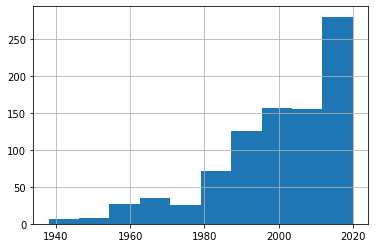

In [7]:
df_main.loc[df_main.YrRenovated>0, 'YrRenovated'].hist()

encode = lambda x: 1 if x>0 else 0
df_main['Renovated'] = df_main.YrRenovated.apply(encode)
df_main.Renovated.value_counts()

#### Create one-hot column for whether there is a garage

1    9814
0    8329
Name: Garage, dtype: int64

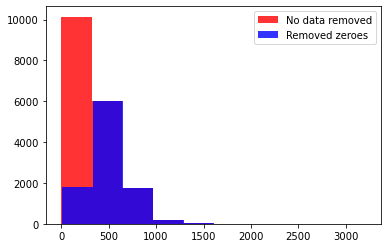

In [8]:
plt.figure()
plt.hist(df_main.SqFtGarageAttached, color='r', alpha=0.8, label='No data removed')
plt.hist(df_main.loc[df_main.SqFtGarageAttached>0, 'SqFtGarageAttached'], color='b', alpha=0.8, label='Removed zeroes')
plt.legend();

encode = lambda x: 1 if x>0 else 0
df_main['Garage'] = df_main.SqFtGarageAttached.apply(encode)
df_main.Garage.value_counts()

0    9585
1    8558
Name: Deck, dtype: int64

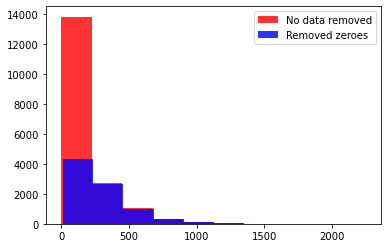

In [9]:
plt.figure()
plt.hist(df_main.SqFtDeck, color='r', alpha=0.8, label='No data removed')
plt.hist(df_main.loc[df_main.SqFtDeck>0, 'SqFtDeck'], color='b', alpha=0.8, label='Removed zeroes')
plt.legend();

encode = lambda x: 1 if x>0 else 0
df_main['Deck'] = df_main.SqFtDeck.apply(encode)
df_main.Deck.value_counts()

#### Indicate whether or not basement is finished

In [10]:
basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
basement.columns = ['fin', 'unfin']

classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
basement['Simplified'] = basement.apply(classify_basements, axis=1)
print(basement.Simplified.value_counts())
basement_dummies = pd.get_dummies(basement.Simplified, prefix='basement', drop_first=False).drop('basement_None', axis=1)

df_main = pd.concat([df_main, basement_dummies], axis=1)
# df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)
# porches.Simplified.value_counts()


None          9417
Unfinished    6329
Finished      2397
Name: Simplified, dtype: int64


In [11]:
##### TRY FORWARD SELECTION #####

#SOURCE: https://planspace.org/20150423-forward_selection_with_statsmodels/

import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [13]:
simplified = df_main.drop(['SalePrice', 'SqFtTotLiving', 'BldgGrade', 'FinBasementGrade', 'YrRenovated'], axis=1)

# **IMPLEMENT NEW FORWARD-SELECTION FEATURE SELECTION**

Current line below appears to be in infinite loop. Troubleshoot accordingly. 

In [ ]:
new_model = forward_selected(simplified, y_log)

In [ ]:
new_model.summary()

# Step-wise feature selection: remove features with low p-value

In [11]:
# Run Step-wise selection algorithm to eliminate irrelevant features
X = df_main.drop(y, axis=1)
keepers = stepwise_selection(X, df_main[y], verbose=True)

# Determine which features were removed
removed = list(df_main.drop(y, axis=1).columns)
for item in keepers:
    removed.remove(item)

print('\nRemaining features:', keepers)
print('\nRemoved features:', removed)


df_removed = df_main[removed].copy()

df_main = df_main[[y] + keepers].copy()

Add  SqFtFinBasement                with p-value 0.0
Add  Bathrooms                      with p-value 0.0
Add  BldgGrade                      with p-value 0.0
Add  YrBuilt                        with p-value 0.0
Add  SqFtTotLiving                  with p-value 5.69727e-135
Add  Bedrooms                       with p-value 1.31849e-120
Add  SqFtGarageAttached             with p-value 1.49713e-81
Drop SqFtFinBasement                with p-value 0.482165
Add  YrRenovated                    with p-value 2.17328e-09
Add  Heating_HotWater               with p-value 3.53294e-08
Add  Heating_FloorWall              with p-value 1.88038e-06
Add  Heating_ElecBB                 with p-value 1.30417e-06
Add  Heating_Other                  with p-value 5.0394e-07
Add  HeatSource_Other               with p-value 4.60187e-05
Add  Condition_VeryGood             with p-value 0.000209514
Add  HeatSource_Oil                 with p-value 0.000583019
Add  Heating_HeatPump               with p-value 0.0005074

# Gain graphical understanding of data

In [12]:
# Pair-plot for non-categorical features
#sns.pairplot(df_main.iloc[:, :8], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'g'}, 'scatter_kws': {'alpha': 0.3}});

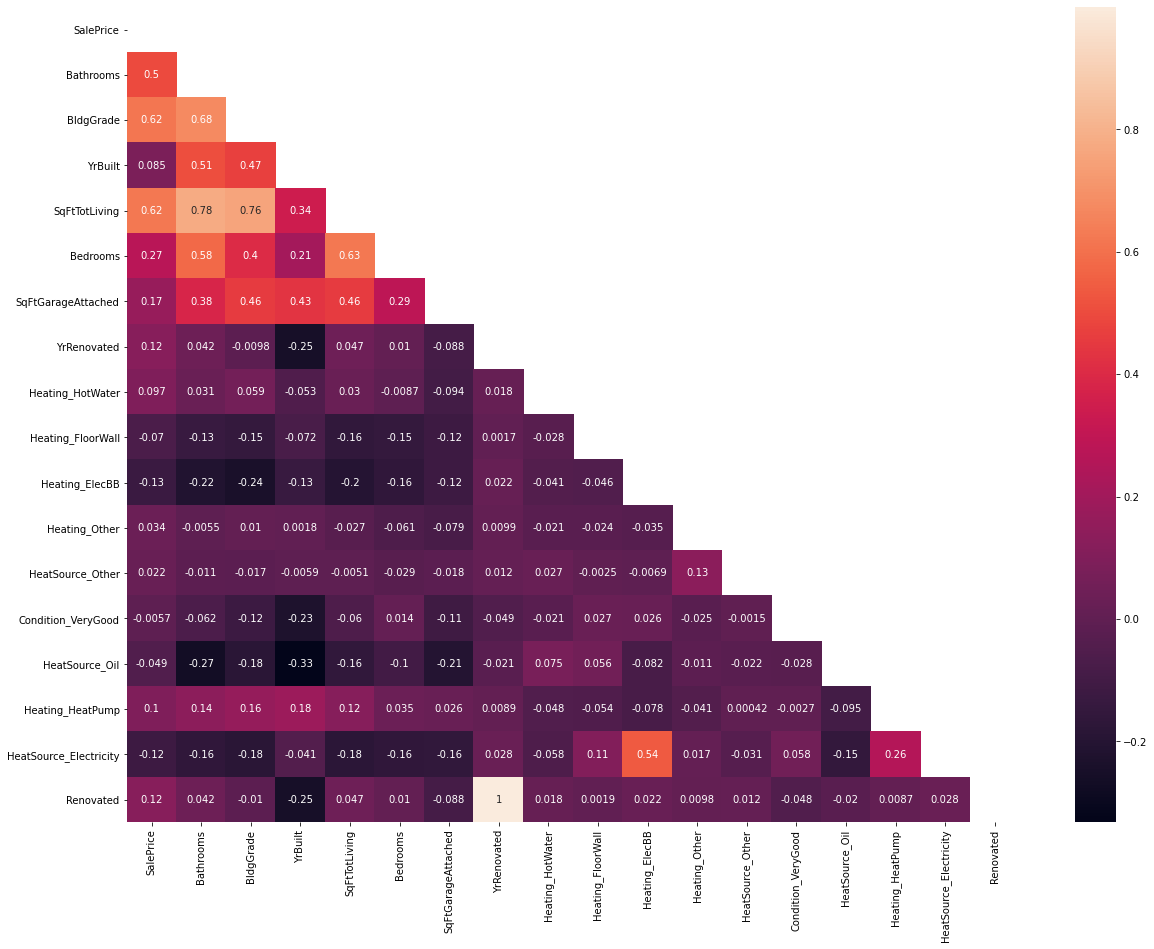

In [13]:
corr = df_main.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # Formula taken from Flatiron School study group material
fig1, ax1 = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, ax=ax1, annot=True);

# Create the single-variable model

#### Start with the feature showing the largest correlation with SalePrice

In [14]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']
correlations['Correlation (abs)'] = correlations['Correlation (abs)'].abs()

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True, ignore_index=True)
correlations

,Dependent,Feature,Correlation (abs)
0,SalePrice,SqFtTotLiving,0.622001
1,SalePrice,BldgGrade,0.615589
2,SalePrice,Bathrooms,0.496065
3,SalePrice,Bedrooms,0.273957
4,SalePrice,SqFtGarageAttached,0.168159
5,SalePrice,Heating_ElecBB,0.126977
6,SalePrice,YrRenovated,0.122163
7,SalePrice,Renovated,0.121942
8,SalePrice,HeatSource_Electricity,0.115226
9,SalePrice,Heating_HeatPump,0.099614


#### Not surprisingly, the livable square footage is amongst the highest predictors

Let's create the simple model and check the assumptions of Linear Regression. Let's also create a dataframe to store the model performance metrics so we can compare them as we go.

In [15]:
col_names = ['Formula', 'Linearity p-value', 'Jarque-Bera (JB) metric', 'JB p-value', 'Lagrange multiplier', 'Lagrange multiplier p-value', 'F-score', 'F-score p-value', 'Average VIF', 'R^2 (Adj.)']
performance_metrics = pd.DataFrame(columns = col_names)

In [16]:
features = ['SqFtTotLiving']
model, df_model = produce_model(df_main, features, y=y)
results = check_assumptions(model, df_model, y, verbose=False, feature_to_plot=features[0])

performance_metrics = performance_metrics.append(results)

Modeling: SalePrice ~ SqFtTotLiving 



#### Clearly, neither SalePrice or SqFtTotLiving are linear. Let's **log-transform** and see the effect

In [12]:
to_log_transform = ['SalePrice', 'SqFtTotLiving']

log_transform = lambda x: np.log(x)
for col in to_log_transform:
    df_main[f'{col}_log'] = df_main[col].apply(log_transform)

In [18]:
features = ['SqFtTotLiving_log']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=features[0])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log 



In [19]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006


In [20]:
df_main.columns

Index(['SalePrice', 'Bathrooms', 'BldgGrade', 'YrBuilt', 'SqFtTotLiving',
       'Bedrooms', 'SqFtGarageAttached', 'YrRenovated', 'Heating_HotWater',
       'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other',
       'HeatSource_Other', 'Condition_VeryGood', 'HeatSource_Oil',
       'Heating_HeatPump', 'HeatSource_Electricity', 'Renovated',
       'SalePrice_log', 'SqFtTotLiving_log'],
      dtype='object')

In [21]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=[])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



In [22]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706


### Add 'Renovated?' to the model

In [23]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'Renovated']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=[])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+Renovated 



In [24]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442


As we see above, "Renovated" didn't add any substantial value to the model. Let's exclude it for now

### Add SqFtGarageAttached to the model

In [25]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'SqFtGarageAttached']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['SqFtGarageAttached'])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached 



In [26]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147


#### We see from the historgram/distplot that SqFtGarageAttached is far from Linear. Let's log transform it then try again.
Note that this does exclude a lot of data since there are lots of homes with no garages, hence 0 sqft, that need to be converted to np.nan since log(0) = -inf

In [27]:
garage_log = df_main.SqFtGarageAttached.map(lambda x: np.nan if x==0 else np.log(x))
df_main['SqFtGarageAttached_log'] = garage_log


features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'SqFtGarageAttached_log']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached_log 



,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699


Phew. That was a terrible addition. Let's keep the non-log transformed version instead.

#### Let's add 'Bedrooms' data

In [28]:
features = ['Bedrooms', 'SqFtTotLiving_log', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['Bedrooms'])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ Bedrooms+SqFtTotLiving_log+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



In [29]:
# Added Bedrooms
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699
0,SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtG...,0.638829,6.457007e+03,0.0,67.561841,4.587626e-12,9.683496,4.368225e-12,6.99613,0.413285


In [30]:
# Removed SqFtLivingArea
# Result: it destroys all metrics. Leave it in.

features = ['Bedrooms', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['Bedrooms'])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ Bedrooms+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



In [31]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699
0,SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtG...,0.638829,6.457007e+03,0.0,67.561841,4.587626e-12,9.683496,4.368225e-12,6.99613,0.413285
0,SalePrice_log~Bedrooms+SqFtGarageAttached+Heat...,0.152911,2.877179e+03,0.0,136.010678,6.957978e-27,22.830854,5.525574e-27,1.41243,0.147747


In [32]:
# Removed 

features = ['SqFtTotLiving', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699
0,SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtG...,0.638829,6.457007e+03,0.0,67.561841,4.587626e-12,9.683496,4.368225e-12,6.99613,0.413285
0,SalePrice_log~Bedrooms+SqFtGarageAttached+Heat...,0.152911,2.877179e+03,0.0,136.010678,6.957978e-27,22.830854,5.525574e-27,1.41243,0.147747
0,SalePrice_log~SqFtTotLiving+SqFtGarageAttached...,0.555153,6.199852e+03,0.0,176.758632,1.655195e-35,29.738130,1.109816e-35,1.50844,0.454811


In [33]:
for x in performance_metrics.Formula:
    print(x)

SalePrice~SqFtTotLiving
SalePrice_log~SqFtTotLiving_log
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+Renovated
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached_log
SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other
SalePrice_log~Bedrooms+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other
SalePrice_log~SqFtTotLiving+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other


In [34]:
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other

SyntaxError: invalid syntax (<ipython-input-34-f5fd74307970>, line 1)

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     2523.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:02:56   Log-Likelihood:                -8444.8
No. Observations:               18143   AIC:                         1.690e+04
Df Residuals:                   18136   BIC:                         1.696e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.6858      0.008   1688.303      0.000      12.671      12.701
SqFtTotLiving          0.0004   3.42e-06    111.868      0.000       0.000       0.000
SqFtGarageAttached    -0.0003   1.12e-05    -23.754      0.000      -0.000      -0.000
Heating_HotWater       0.1767      0.019      9.478      0.000       0.140       0.213
Heating_FloorWall     -0.0163      0.017     -0.968      0.333      -0.049       0.017
Heating_ElecBB        -0.1328      0.012    -10.891      0.000      -0.157      -0.109
Heating_Other          0.2046      0.022      9.417      0.000       0.162       0.247
==============================================================================
Omnibus:                     1241.410   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6199.852
Skew:                          -0.076   Prob(JB):                         0.00
Kurtosis:                       5.860   Cond. No.                     1.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     2085.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:03:06   Log-Likelihood:            -1.3738e+05
No. Observations:                9814   AIC:                         2.748e+05
Df Residuals:                    9795   BIC:                         2.749e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.436e+06    4.1e+05     -5.937      0.000   -3.24e+06   -1.63e+06
SalePrice_log           9.107e+05   9050.048    100.633      0.000    8.93e+05    9.28e+05
SqFtTotLiving            492.5363     11.432     43.084      0.000     470.127     514.946
SqFtTotLiving_log      -1.171e+06   2.75e+04    -42.659      0.000   -1.23e+06   -1.12e+06
SqFtGarageAttached_log  1.205e+05   1.55e+04      7.759      0.000    9.01e+04    1.51e+05
SqFtGarageAttached      -388.9482     38.174    -10.189      0.000    -463.776    -314.120
Bathrooms               7.555e+04   7486.710     10.091      0.000    6.09e+04    9.02e+04
Renovated               5.077e+06   2.44e+06      2.080      0.038    2.91e+05    9.86e+06
Bedrooms               -2.693e+04   4802.640     -5.608      0.000   -3.63e+04   -1.75e+04
Heating_HotWater        1.377e+05   3.02e+04      4.563      0.000    7.86e+04    1.97e+05
BldgGrade               2.432e+04   4757.109      5.112      0.000     1.5e+04    3.36e+04
YrBuilt                 -995.9053    190.778     -5.220      0.000   -1369.869    -621.941
Heating_Other          -9.477e+04    3.6e+04     -2.636      0.008   -1.65e+05   -2.43e+04
Heating_FloorWall      -5.883e+04   2.73e+04     -2.151      0.031   -1.12e+05   -5222.758
Heating_HeatPump       -1.926e+04   1.13e+04     -1.697      0.090   -4.15e+04    2981.727
YrRenovated            -2473.4113   1219.027     -2.029      0.042   -4862.956     -83.866
HeatSource_Other       -1.083e+05   5.44e+04     -1.993      0.046   -2.15e+05   -1761.885
HeatSource_Oil          -2.91e+04   1.63e+04     -1.786      0.074    -6.1e+04    2843.090
HeatSource_Electricity -1.073e+04   9597.125     -1.118      0.264   -2.95e+04    8085.598
==============================================================================
Omnibus:                    19646.515   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        108106541.110
Skew:                          16.023   Prob(JB):                         0.00
Kurtosis:                     516.173   Cond. No.                     2.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""